<a href="https://colab.research.google.com/github/ap15032005/viscosity-Ann-Svr/blob/main/Vis_ANN_SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import History


In [2]:
from google.colab import files
uploaded = files.upload()


Saving viscosity_final dataset.xlsm to viscosity_final dataset.xlsm


In [3]:
df = pd.read_excel("viscosity_final dataset.xlsm")

print(df.head())
print(df.columns)


   Y_viscosity  X1_Temperature_C  X2_Concentration  X3_BaseFluid_viscosity
0      0.01690                25               0.0                  0.0169
1      0.01792                25               0.5                  0.0169
2      0.01904                25               1.0                  0.0169
3      0.02056                25               1.5                  0.0169
4      0.02279                25               2.0                  0.0169
Index(['Y_viscosity', 'X1_Temperature_C', 'X2_Concentration',
       'X3_BaseFluid_viscosity'],
      dtype='object')


In [4]:
y = df.iloc[:, 0].values        # FIRST column = viscosity
X = df.iloc[:, 1:].values       # Remaining columns = X features


In [5]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()


In [6]:
from sklearn.model_selection import train_test_split

def split_data(test_size):
    return train_test_split(
        X_scaled,
        y_scaled,
        test_size=test_size,
        random_state=42
    )


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)     # MSME interpreted as RMSE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2


SUPPORT VECTOR REGRESSION

In [8]:
from sklearn.svm import SVR

def train_svr_model(X_train, X_test, y_train, y_test):
    svr = SVR(kernel='poly', degree=3)
    svr.fit(X_train, y_train)

    y_pred = svr.predict(X_test)
    metrics = evaluate_metrics(y_test, y_pred)

    return metrics, y_test, y_pred


In [9]:
svr_splits = {
    "80_20": 0.2,
    "70_30": 0.3,
    "60_40": 0.4
}

svr_results = {}


In [10]:
for split_name, test_size in svr_splits.items():
    X_train, X_test, y_train, y_test = split_data(test_size)

    metrics, y_true, y_pred = train_svr_model(
        X_train, X_test, y_train, y_test
    )

    svr_results[split_name] = {
        "metrics": metrics,
        "y_true": y_true,
        "y_pred": y_pred
    }


In [11]:
print("SVR PERFORMANCE RESULTS\n")

for split in svr_results:
    mse, rmse, mae, r2 = svr_results[split]["metrics"]
    print(f"Split {split}")
    print(f"  MSE  = {mse:.6f}")
    print(f"  RMSE = {rmse:.6f}")
    print(f"  MAE  = {mae:.6f}")
    print(f"  R²   = {r2:.6f}")
    print("-" * 30)


SVR PERFORMANCE RESULTS

Split 80_20
  MSE  = 0.112134
  RMSE = 0.334865
  MAE  = 0.271267
  R²   = 0.899486
------------------------------
Split 70_30
  MSE  = 0.115799
  RMSE = 0.340292
  MAE  = 0.277112
  R²   = 0.887720
------------------------------
Split 60_40
  MSE  = 0.106671
  RMSE = 0.326605
  MAE  = 0.265552
  R²   = 0.894449
------------------------------


SVR GRAPHS

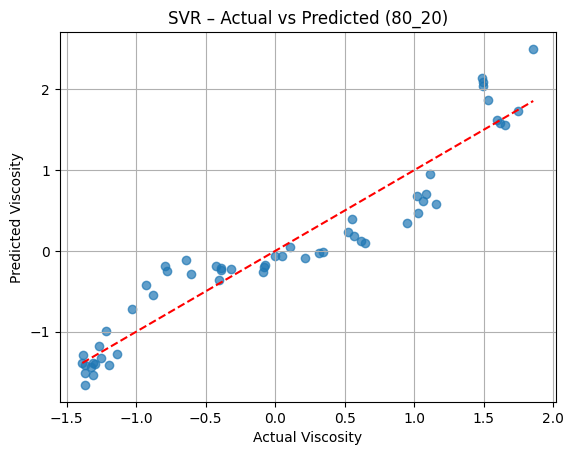

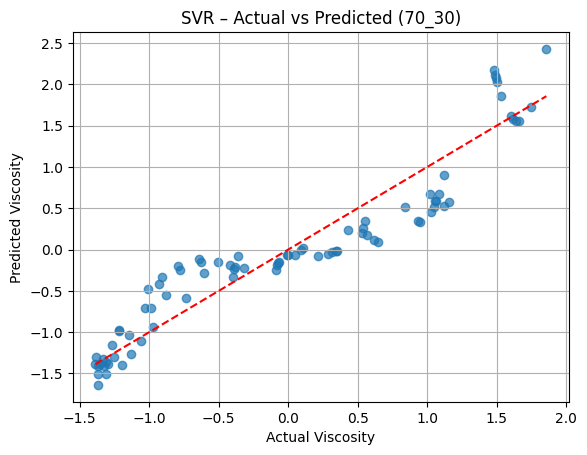

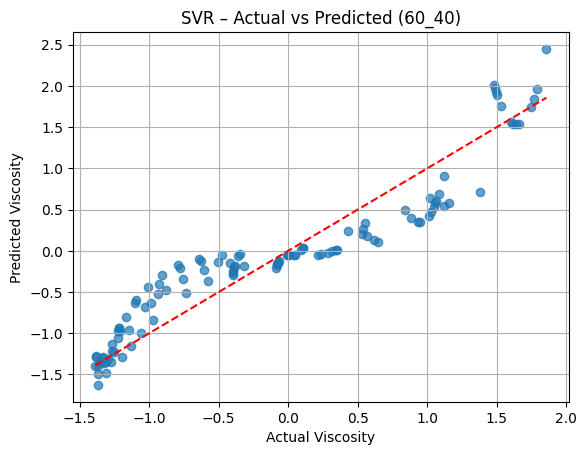

In [12]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred_svr(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        'r--'
    )
    plt.xlabel("Actual Viscosity")
    plt.ylabel("Predicted Viscosity")
    plt.title(title)
    plt.grid()
    plt.show()

for split in svr_results:
    plot_actual_vs_pred_svr(
        svr_results[split]["y_true"],
        svr_results[split]["y_pred"],
        f"SVR – Actual vs Predicted ({split})"
    )


MODEL 2: ANN (AFTER SVR)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [14]:
def build_ann(input_dim):
    model = Sequential([
        Dense(16, activation='relu', input_shape=(input_dim,)),
        Dense(20, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mse'
    )
    return model


In [15]:
def train_ann_model(X_train, X_test, y_train, y_test):
    model = build_ann(X_train.shape[1])

    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=16,
        validation_split=0.1,
        verbose=0
    )

    y_pred = model.predict(X_test).ravel()
    metrics = evaluate_metrics(y_test, y_pred)

    return history.history['loss'], metrics, y_test, y_pred


In [16]:
ann_splits = {
    "80_20": 0.2,
    "70_30": 0.3,
    "60_40": 0.4
}

ann_results = {}


In [17]:
for split_name, test_size in ann_splits.items():
    X_train, X_test, y_train, y_test = split_data(test_size)

    loss, metrics, y_true, y_pred = train_ann_model(
        X_train, X_test, y_train, y_test
    )

    ann_results[split_name] = {
        "loss": loss,
        "metrics": metrics,
        "y_true": y_true,
        "y_pred": y_pred
    }


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [18]:
print("ANN PERFORMANCE RESULTS\n")

for split in ann_results:
    mse, rmse, mae, r2 = ann_results[split]["metrics"]
    print(f"Split {split}")
    print(f"  MSE  = {mse:.6f}")
    print(f"  RMSE = {rmse:.6f}")
    print(f"  MAE  = {mae:.6f}")
    print(f"  R²   = {r2:.6f}")
    print("-" * 30)


ANN PERFORMANCE RESULTS

Split 80_20
  MSE  = 0.000905
  RMSE = 0.030081
  MAE  = 0.018767
  R²   = 0.999189
------------------------------
Split 70_30
  MSE  = 0.001245
  RMSE = 0.035286
  MAE  = 0.023301
  R²   = 0.998793
------------------------------
Split 60_40
  MSE  = 0.001659
  RMSE = 0.040725
  MAE  = 0.024232
  R²   = 0.998359
------------------------------


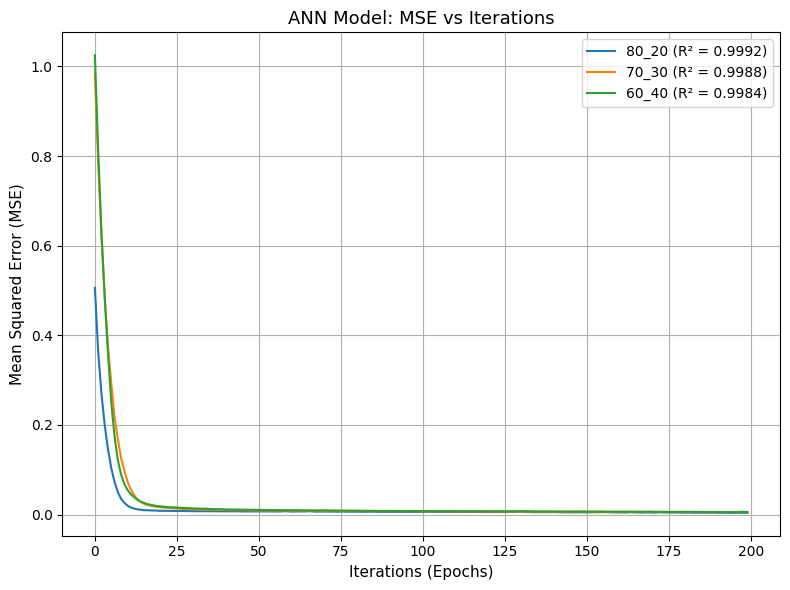

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for split in ann_results:
    loss = ann_results[split]["loss"]
    r2 = ann_results[split]["metrics"][3]  # R² value

    plt.plot(
        loss,
        label=f"{split} (R² = {r2:.4f})"
    )

plt.xlabel("Iterations (Epochs)", fontsize=11)
plt.ylabel("Mean Squared Error (MSE)", fontsize=11)
plt.title("ANN Model: MSE vs Iterations", fontsize=13)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



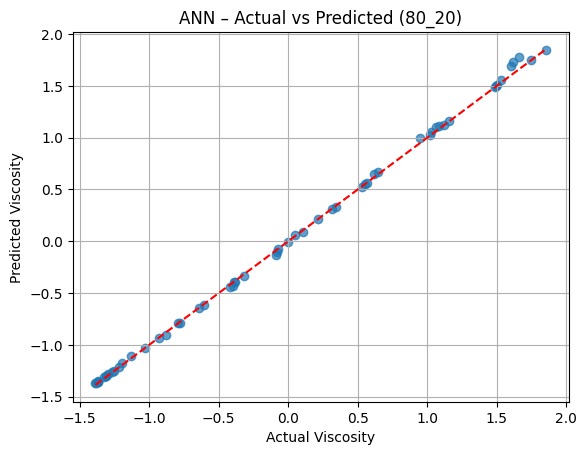

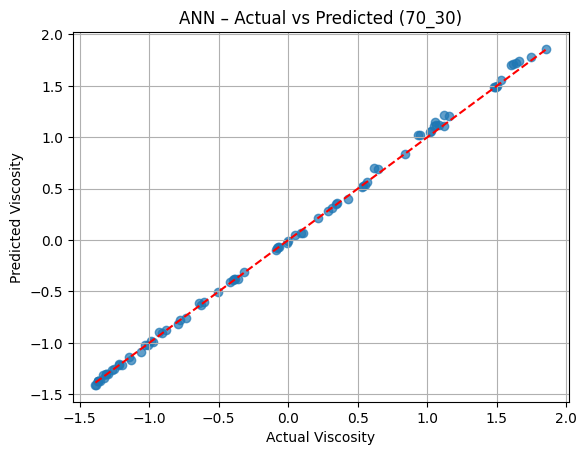

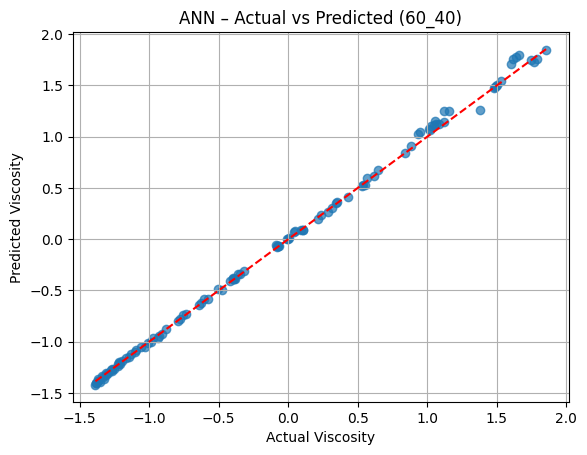

In [20]:
def plot_actual_vs_pred_ann(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        'r--'
    )
    plt.xlabel("Actual Viscosity")
    plt.ylabel("Predicted Viscosity")
    plt.title(title)
    plt.grid()
    plt.show()

for split in ann_results:
    plot_actual_vs_pred_ann(
        ann_results[split]["y_true"],
        ann_results[split]["y_pred"],
        f"ANN – Actual vs Predicted ({split})"
    )
